In [1]:
import pandas as pd
from alpha_vantage.timeseries import TimeSeries
import time
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, LSTM
from statsmodels.tsa.ar_model import AR

def predict_LSTM(ticker):
    api_key = '36N2WM8I8W74IFZ0'
    ts = TimeSeries(key=api_key, output_format='pandas')
    data, meta_data = ts.get_daily(symbol=ticker, outputsize = 'full')
    data = data.reindex(index=data.index[::-1])
    close_data = data['4. close'][len(data)-1000:len(data)]
    
    model = load_model('my_model.h5')
    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_data = scaler.fit_transform(close_data.values.reshape(-1,1))
    
    prediction_days = 100

    x_set = []
    y_set = []

    for x in range(prediction_days, len(scaled_data)):
        x_set.append(scaled_data[x-prediction_days:x, 0])
        y_set.append(scaled_data[x, 0])
    
    x_set, y_set = np.array(x_set), np.array(y_set)
    x_set = np.reshape(x_set, (x_set.shape[0], x_set.shape[1], 1))
    
    predicted_prices = model.predict(x_set)
    predicted_prices = scaler.inverse_transform(predicted_prices)
    
    return(predicted_prices)

def predict_AR(ticker):
    api_key = '36N2WM8I8W74IFZ0'
    ts = TimeSeries(key=api_key, output_format='pandas')
    data, meta_data = ts.get_daily(symbol=ticker, outputsize = 'full')
    data = data.reindex(index=data.index[::-1])
    close_data = data['4. close']
    
    close_data = np.array(close_data)
    x_train = close_data
    model = AR(x_train)
    model_fit = model.fit()
    predicted_prices = model_fit.predict(start=len(x_train), end=len(x_train)+90, dynamic=True)
    
    return(predicted_prices)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\А\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\ar_model.py:791: FutureWarning: 
statsmodels.tsa.AR has been deprecated in favor of statsmodels.tsa.AutoReg and
statsmodels.tsa.SARIMAX.

AutoReg adds the ability to specify exogenous variables, include time trends,
and add seasonal dummies. The AutoReg API differs from AR since the model is
treated as immutable, and so the entire specification including the lag
length must be specified when creating the model. This change is too
substantial to incorporate into the existing AR api. The function
ar_select_order performs lag length selection for AutoReg models.

AutoReg only estimates parameters using conditional MLE (OLS). Use SARIMAX to
estimate ARX and related models using full MLE via the Kalman Filter.

To silence this warning and continue using AR until it is removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels

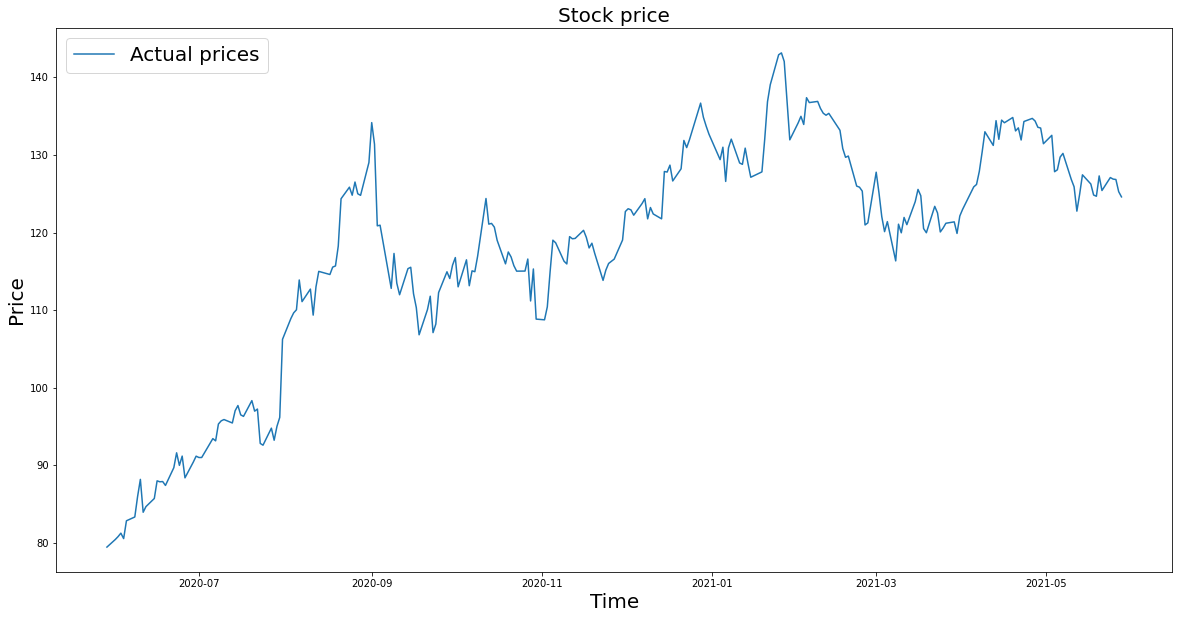

In [2]:
import telebot
import config
import matplotlib.pyplot as plt
from telebot import types
import yfinance as yf

bot = telebot.TeleBot('1699729142:AAEn24rzjPmVGP9pJlCvN4XrdFS1CS9Fw-s')

@bot.message_handler(commands = ['start'])
def greet(message):
    bot.send_message(message.chat.id,"Hello!\nThis is financial bot, which provides you with necessary financial info and uses several models to make predictions.\nUse /help to get more info.")

commands = {
    'price'         : 'Get stock prices in real time',
    'graph'         : 'Get a graph of stock prices',
    'predict_lstm'  : 'Get predicted prices using LSTM model (1 month only)',
    'predict_ar'    : 'Get predicted prices using AR model (1 day only)'
}
    
@bot.message_handler(commands=['help'])
def command_help(message):
    cid = message.chat.id
    help_text = "The following commands are available: \n"
    for key in commands:
        help_text += "'" + key + "': "
        help_text += commands[key] + "\n"
    bot.send_message(cid, help_text)
    bot.send_message(cid, 'Use any of these commands + ticker (e.g. price TSLA) \nOr write /all to open the menu.')

@bot.message_handler(commands=['all'])
def start_message(message):
    markup = types.InlineKeyboardMarkup()
    markup.add(types.InlineKeyboardButton(text='Price', callback_data=1))
    markup.add(types.InlineKeyboardButton(text='Graph', callback_data=2))
    markup.add(types.InlineKeyboardButton(text='Predict', callback_data=3))
    bot.send_message(message.chat.id, text="Choose appropriate feature", reply_markup=markup)

def stock_request(message):
    request = message.text.split()
    if len(request) < 2 or request[0].lower() not in "price":
        return False
    else:
        return True

@bot.message_handler(func=stock_request)
def send_price(message):
    request = message.text.split()[1]
    data = yf.download(tickers=request, period='7d', interval='1d')
    data = data.reset_index()
    data["format_date"] = data['Date'].dt.strftime('%m/%d')
    data.set_index('format_date', inplace=True)
    bot.send_message(message.chat.id, 'Here are stock prices for last 7 days')
    bot.send_message(message.chat.id, data['Close'].to_string(header=False))
    
def graph_request(message):
    request = message.text.split()
    if len(request) < 2 or request[0].lower() not in "graph":
        return False
    else:
        return True

@bot.message_handler(func=graph_request)
def send_graph(message):
    request = message.text.split()[1]
    data = yf.download(tickers=request, period='1y', interval='1d')
    close_data = data['Close']
    plt.figure(figsize=(20,10))
    plt.plot(close_data, label="Actual prices")
    plt.title(f'Stock price', fontsize=20)
    plt.xlabel('Time', fontsize=20)
    plt.ylabel('Price', fontsize=20)
    plt.legend(loc='upper left', fontsize=20)
    plt.savefig("graph")
    graph = open('graph.png', 'rb')
    bot.send_message(message.chat.id, 'Here is the graph for last year')
    bot.send_photo(message.chat.id, graph)

def predict_request_LSTM(message):
    request = message.text.split()
    if len(request) < 2 or request[0].lower() not in "predict_lstm":
        return False
    else:
        return True

@bot.message_handler(func=predict_request_LSTM)
def send_predict_LSTM(message):
    ticker = message.text.split()[1]
    predicted_prices = predict_LSTM(ticker)
    prediction = predicted_prices[len(predicted_prices)-1][0]
    prediction = round(prediction, 2)
    bot.send_message(message.chat.id, "Predicted price for tomorrow:")
    bot.send_message(message.chat.id, prediction)
    
@bot.callback_query_handler(func=lambda call: True)
def query_handler(call):
    if call.data == '1':
        mesg = bot.send_message(call.message.chat.id, 'Enter ticker')
        bot.register_next_step_handler(mesg, send_price)
    elif call.data == '2':
        mesg = bot.send_message(call.message.chat.id, 'Enter ticker')
        bot.register_next_step_handler(mesg, send_graph)
    elif call.data == '3':
        markup = types.InlineKeyboardMarkup()
        markup.add(types.InlineKeyboardButton(text='Month', callback_data=4))
        markup.add(types.InlineKeyboardButton(text='Day', callback_data=5))
        bot.send_message(call.message.chat.id, text="Choose forecast time period", reply_markup=markup)
    elif call.data == '4':
        mesg = bot.send_message(call.message.chat.id, 'Enter ticker')
        bot.register_next_step_handler(mesg, send_predict_AR)
    elif call.data == '5':
        mesg = bot.send_message(call.message.chat.id, 'Enter ticker')
        bot.register_next_step_handler(mesg, send_predict_LSTM)
    
def send_price(message):
    request = message.text.split()[0]
    data = yf.download(tickers=request, period='7d', interval='1d')
    data = data.reset_index()
    data["format_date"] = data['Date'].dt.strftime('%m/%d')
    data.set_index('format_date', inplace=True)
    bot.send_message(message.chat.id, 'Here are stock prices for last 7 days')
    bot.send_message(message.chat.id, data['Close'].to_string(header=False))
        
def send_graph(message):
    request = message.text.split()[0]
    data = yf.download(tickers=request, period='1y', interval='1d')
    close_data = data['Close']
    plt.figure(figsize=(20,10))
    plt.plot(close_data, label="Actual prices")
    plt.title(f'Stock price', fontsize=20)
    plt.xlabel('Time', fontsize=20)
    plt.ylabel('Price', fontsize=20)
    plt.legend(loc='upper left', fontsize=20)
    plt.savefig("graph")
    graph = open('graph.png', 'rb')
    bot.send_message(message.chat.id, 'Here is the graph for last year')
    bot.send_photo(message.chat.id, graph)
    
def send_predict_LSTM(message):
    ticker = message.text.split()[0]
    predicted_prices = predict_LSTM(ticker)
    prediction = predicted_prices[len(predicted_prices)-1][0]
    prediction = round(prediction, 2)
    bot.send_message(message.chat.id, "Predicted price for tomorrow:")
    bot.send_message(message.chat.id, prediction)
    
def send_predict_AR(message):
    ticker = message.text.split()[0]
    predicted_prices = predict_AR(ticker)
    prediction = predicted_prices[len(predicted_prices)-1]
    prediction = round(prediction, 2)
    bot.send_message(message.chat.id, "Predicted price for next month:")
    bot.send_message(message.chat.id, prediction)
    
def predict_request_AR(message):
    request = message.text.split()
    if len(request) < 2 or request[0].lower() not in "predict_ar":
        return False
    else:
        return True

@bot.message_handler(func=predict_request_AR)
def send_predict_request_AR(message):
    ticker = message.text.split()[1]
    predicted_prices = predict_AR(ticker)
    prediction = predicted_prices[len(predicted_prices)-1]
    prediction = round(prediction, 2)
    bot.send_message(message.chat.id, "Predicted price for next month:")
    bot.send_message(message.chat.id, prediction)
        
bot.polling()